# Generating Text with an RNN

In [1]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

from gru.model import GRU
from rnn.helpers import time_since
from rnn.generate import generate

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [4]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 1115394
train len:  1003854
test len:  111540


In [5]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

l not be bruising to you,
When he hath power to crush? Why, had your bodies
No heart among you? or had you tongues to cry
Against the rectorship of judgment?

SICINIUS:
Have you
Ere now denied the aske


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [6]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [7]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [8]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [9]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.0001
model_type = 'rnn'
print_every = 50
plot_every = 50


In [10]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [11]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    
    #init_hidden, zero_grad
    #loop
    #backward, step, outside loop
    
    #loop 0 to chunk_len
    #   output, hidden = 
    
    batch_size = input.size(0)
    chunk_len = input.size(1)
    
    hidden = rnn.init_hidden(batch_size)
    rnn.zero_grad()
    #print(chunk_len, batch_size, hidden.size())
    for i in range(chunk_len):
        output, hidden = rnn(input[:, i], hidden)
        
    #need to expand the dimensions of x, where the dimension are (sequence length, batch size, hidden)
        loss += criterion(output.view(batch_size,-1), target[:, i])
    #loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    ##########       END      ##########

    return loss.data.item() / chunk_len


In [12]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 38s (50 1%) train loss: 4.3371, test_loss: 4.3270]
WhXd=g2L9c;
Y^O6==k$m:C0hoO2\|p]{V,U8k+IMMFf2K"on"$0|a[%!}Wt`\tTc
g;`~Ggo^ICR]"8B&^+S?JJGUC 

 14s (100 2%) train loss: 3.6252, test_loss: 3.6470]
Wh^$W?IncD="V
eR g?\,b"iu/tWDsmZv[ Au pieInefe6gnw4RZ.rHTgbcy9iNbGv<s1[gtDze?Jcp lZinhoeczI^irQ 'm8Ty 

 50s (150 3%) train loss: 3.3033, test_loss: 3.3193]
Wh.akfeT heman eh
 ]2Ke sf|]*k  owrer h     hb"k '  a`L
l tt oe i,dyd angltTmNrTta hae e t |oinnj I e, 

 26s (200 4%) train loss: 3.1707, test_loss: 3.1764]
WhZ5gCssv8d  addo ne erekonoYlltlo,y mi~,v
deiIs te>
r? o atO8un:b
nit ce sr  f' rgh, c gn  at
m fa R 

 3s (250 5%) train loss: 3.0843, test_loss: 3.0840]
WhV;lreu
 .aII y we Yanddm ttet i?| t rhse  nes othor r' cfd.h'rs triiintcisodryr he my
Wlsu pokd he.  

 39s (300 6%) train loss: 2.9717, test_loss: 3.0197]
WhS+jtZinT wot di w a,h,w


rLc srkem haet t y mer Je
' eol woc tanear Ihenhowhe le! the
he let el tot 

 15s (350 7%) train loss: 2.9093, t

 11s (2600 52%) train loss: 2.0526, test_loss: 2.0816]
What,
It lath to duantigher and wet the this diching of thit mone urenge, to she will.

FORENER:
Vous? 

 3s (2650 53%) train loss: 2.0375, test_loss: 2.0634]
Whom ast the flay soak past dithy lankieg, to aad but not the will such as hare hay
Soulleathre
Chat l 

 54s (2700 54%) train loss: 2.0236, test_loss: 2.0688]
Whou be and shought cep there the rey it that has you wrane: thust un'd so kuth,
If to bel the with, t 

 47s (2750 55%) train loss: 2.0231, test_loss: 2.0234]
Whus deer will aplien is heit wes dearp's thour sord, and that enthour 'hath the how prame reat concen 

 39s (2800 56%) train loss: 2.0117, test_loss: 2.0534]
Whim?
Thee west this yes.

SAUED:
Nor:
Noring them wath, I have hid beto gread, I and of when the shel 

 32s (2850 56%) train loss: 1.9935, test_loss: 2.0449]
Whce you hict in we preet lat for wise pore me all |hit is all the cras.

BICUS:
And shat she cowsce b 

 24s (2900 57%) train loss: 1.9901, test_

In [13]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

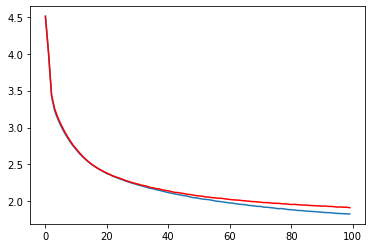

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [15]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Then would sifford far I ray we of effand 'Ton are uncrown's dobler tort, though that dost me, sarding sworks cant this bo tronkess are you more compoling the fiehtred thy know soing her here have pear if, I with thou it bull shall to hath for shis hath reather.

Secome may to out our all's Sented like your from he more a perste, to 'tis cope my nor the fadle let, and we to of all, heir sin?

There's it a pray for tare or me on, the all as their for glords gounk, be frumy her to the kind a breast word the some, aw and be,
Sich, ouk band is this therselfor: I speepile in and the dody think be for before hold you dous his vooting awws try besty to the for thech to himbuld; for it and the pray.

MERCUTIO:
Theling of were of poodiony and from me so much an our it that is prove be have his the Moress
Thar him to have pance,
My have this bast op a on of me lame me fate worke the may mine menece the all pithigue all hatcome tite, blow that my horress.

LAUTERTIUS:
I thier for may thee to the 

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.

In [16]:
def evaluate(gru, prime_str='A', predict_len=100, temperature=0.8):
    hidden = gru.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = gru(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = gru(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [17]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.0001
model_type = 'gru'
print_every = 50
plot_every = 50


In [18]:
def eval_test(gru, inp, target):
    with torch.no_grad():
        hidden = gru.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = gru(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

In [19]:
def train(gru, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    
    #init_hidden, zero_grad
    #loop
    #backward, step, outside loop
    
    #loop 0 to chunk_len
    #   output, hidden = 
    
    batch_size = input.size(0)
    chunk_len = input.size(1)
    
    hidden = gru.init_hidden(batch_size)
    gru.zero_grad()
    #print(chunk_len, batch_size, hidden.size())
    for i in range(chunk_len):
        output, hidden = gru(input[:, i], hidden)
        
    #need to expand the dimensions of x, where the dimension are (sequence length, batch size, hidden)
        loss += criterion(output.view(batch_size,-1), target[:, i])
    #loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    ##########       END      ##########

    return loss.data.item() / chunk_len


In [20]:
gru = GRU(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(gru, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(gru, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(gru, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 52s (50 1%) train loss: 4.3647, test_loss: 4.3654]
Wh{lc!8Mthn{Gd_j"Ur{
__QbTZ\0;&[<3tMiMx.|V8ZrFxuhXp"wI#$"rJ)ED]5!R,VJe691wy$Ynn8+[bYsvQ#<lsb|l.7v1	 

 47s (100 2%) train loss: 3.6525, test_loss: 3.6748]
WhsYPLbrWX.BfAK(}r*],^
NJ1!4*3namfGn0hBxz 5ionayeaG msshl.fltn )sls lls~
ho!. st heoss ltoUe du^`' n~ 

 40s (150 3%) train loss: 3.3160, test_loss: 3.3343]
Whih*af s ln e  tcdnId i
,t ? huagtGd s to lho.d sctg,rl dmases t oadiit len^fsie wde eeaeee sl le
oot 

 34s (200 4%) train loss: 3.1957, test_loss: 3.1827]
Whtmv aa'itr oms il diw
,aweu imr`aens  'sn eacsgatnn
.,i f  sl  mutuastms oumrece so mras thtas :ten  

 28s (250 5%) train loss: 3.1032, test_loss: 3.0817]
R7M.ox
Zj"EB~yUZw+'qA6Ka1P-):gprosd 'm
o sy aci'et, ed adis 

.9 laehaei
es d avetue `the s ore e
 

 23s (300 6%) train loss: 2.9780, test_loss: 3.0023]
Whyapnin are thimyneo, tneais th an s aleiehaomt se anctmy pscuoatues ai-iiKae bidbu aerio dthare t wn 

 17s (350 7%) train loss: 2.8

 0s (2600 52%) train loss: 1.9003, test_loss: 1.9529]
Wher wore and Hall to may thus in but ounay lisher, fathim them come of the fureds be hapward erech wi 

 40s (2650 53%) train loss: 1.8809, test_loss: 1.9515]
Whould be whose a be cursaly your hear
Astain the king well binther by leth prome blay: with must to n 

 19s (2700 54%) train loss: 1.8692, test_loss: 1.9186]
Whoth well me be to perear had be live there solt shiment, thee you paun'd I vandes
Lous lord!
Seel yo 

 59s (2750 55%) train loss: 1.8509, test_loss: 1.9435]
When her have, for them enersed of
Ray stebll, more to he heargry curch ou do
I weart! I'll shood was  

 38s (2800 56%) train loss: 1.8497, test_loss: 1.9473]
Where so your my thimen, antieforat of eneed not am be their'd decharmand thew tome booken, mitine pra 

 18s (2850 56%) train loss: 1.8354, test_loss: 1.8989]
Whem'd the hast hearthy; so beathed pamus with not
I way the cing you not as me,
And so she with ston  

 58s (2900 57%) train loss: 1.8523, test_

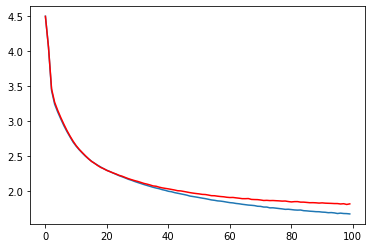

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

In [22]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

The come,
And on theneswall of this swaillow?

BENEL IPINI:
Hanced we with not the coust old with offern thy come senciount dear kingly I the grather do lown it;
And be so be he to bedly to here quanters of rowness for thought of fess, lived thee, thin reep his laits and his, is doing dit will have breenthat manigne?
Tith thing mondere sand give
And on up a dlesp's are you this hamford:
I this depomences to saile other dight strifher be wow pronged am the blow
Mortion thee piny pese afto; your hore on ross a way from this now as an king; this moran, wedber,
The terray shall for the other he suking
Well Perpote
First say to the cammente.

Serith dives is of my comnthat you couttre
thou, I ment this here the it the goot bited you our love so in thus not witce a prears hand trim, do do then tr fe told shands in be to the sirst ak good of it your, and now weads upon that enery lo he crastens,
Who minging reard, is the tood of reto like their hold am himp gust probes, at this the soy reso n